In [1]:

import numpy as np
import pandas as pd
import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, GRU, Conv1D, GlobalMaxPooling1D, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')







In [2]:

# Configuration
RANDOM_STATE = 42
LSA_COMPONENTS = 100
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Définir le chemin de base
base = r"C:\Users\hp\Desktop\pfemaster\vectors"


In [3]:
base = r"C:\Users\hp\Desktop\pfemaster\vectors"


In [4]:
# Chargement des 5 types de vecteurs
X_train_tfidf = joblib.load(base + "/X_train_tfidf.pkl")
X_test_tfidf = joblib.load(base + "/X_test_tfidf.pkl")

X_train_glove = joblib.load(base + "/X_train_glove.pkl")
X_test_glove = joblib.load(base + "/X_test_glove.pkl")

X_train_w2v = joblib.load(base + "/X_train_w2v.pkl")
X_test_w2v = joblib.load(base + "/X_test_w2v.pkl")

X_train_bert = joblib.load(base + "/X_train_bert.pkl")
X_test_bert = joblib.load(base + "/X_test_bert.pkl")

X_train_bert_2 = joblib.load(base + "/X_train_bert_2.pkl")
X_test_bert_2 = joblib.load(base + "/X_test_bert_2.pkl")

y_train = joblib.load(base + "/y_train.pkl")
y_test = joblib.load(base + "/y_test.pkl")

print("✅ Vecteurs chargés avec succès!")
print(f"📊 Formes des données:")
print(f"   TF-IDF: {X_train_tfidf.shape}")
print(f"   GloVe: {X_train_glove.shape}")
print(f"   Word2Vec: {X_train_w2v.shape}")
print(f"   BERT: {X_train_bert.shape}")
print(f"   BERT_2: {X_train_bert_2.shape}")

✅ Vecteurs chargés avec succès!
📊 Formes des données:
   TF-IDF: (19761, 5652)
   GloVe: (19761, 200)
   Word2Vec: (19761, 100)
   BERT: (19761, 768)
   BERT_2: (19761, 768)


In [5]:
# Encoder les labels si nécessaire
label_encoder = LabelEncoder()
if y_train.dtype == 'object' or isinstance(y_train[0], str):
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
else:
    y_train_encoded = y_train
    y_test_encoded = y_test

# Conversion en format catégoriel pour Keras
num_classes = len(np.unique(y_train_encoded))
y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

print(f"🎯 Nombre de classes: {num_classes}")

🎯 Nombre de classes: 3


In [6]:

print("\n🔬 Application de LSA sur chaque type de vecteur...")

# Classification des vecteurs par type
vector_groups = {
    'sparse': {  # Vecteurs creux (TF-IDF)
        'tfidf': (X_train_tfidf, X_test_tfidf)
    },
    'dense_semantic': {  # Vecteurs denses sémantiques (GloVe, Word2Vec)
        'glove': (X_train_glove, X_test_glove),
        'w2v': (X_train_w2v, X_test_w2v)
    },
    'contextual': {  # Vecteurs contextuels (BERT)
        'bert': (X_train_bert, X_test_bert),
        'bert_2': (X_train_bert_2, X_test_bert_2)
    }
}

# Application de LSA
lsa_vectors = {}
lsa_models = {}
scalers = {}

for group_name, vectors in vector_groups.items():
    print(f"\n📈 Traitement du groupe {group_name.upper()}...")
    
    for vector_name, (X_train_vec, X_test_vec) in vectors.items():
        print(f"   🔧 {vector_name}...")
        
        # Normalisation
        scaler = StandardScaler(with_mean=False)
        X_train_scaled = scaler.fit_transform(X_train_vec)
        X_test_scaled = scaler.transform(X_test_vec)
        
        # LSA
        n_components = min(LSA_COMPONENTS, X_train_scaled.shape[1] - 1, X_train_scaled.shape[0] - 1)
        lsa = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
        
        X_train_lsa = lsa.fit_transform(X_train_scaled)
        X_test_lsa = lsa.transform(X_test_scaled)
        
        # Stockage
        lsa_vectors[vector_name] = (X_train_lsa, X_test_lsa)
        lsa_models[vector_name] = lsa
        scalers[vector_name] = scaler
        
        print(f"      ✅ {X_train_vec.shape} → {X_train_lsa.shape} (Variance: {lsa.explained_variance_ratio_.sum():.3f})")



🔬 Application de LSA sur chaque type de vecteur...

📈 Traitement du groupe SPARSE...
   🔧 tfidf...
      ✅ (19761, 5652) → (19761, 100) (Variance: 0.051)

📈 Traitement du groupe DENSE_SEMANTIC...
   🔧 glove...
      ✅ (19761, 200) → (19761, 100) (Variance: 1.000)
   🔧 w2v...
      ✅ (19761, 100) → (19761, 99) (Variance: 1.000)

📈 Traitement du groupe CONTEXTUAL...
   🔧 bert...
      ✅ (19761, 768) → (19761, 100) (Variance: 0.810)
   🔧 bert_2...
      ✅ (19761, 768) → (19761, 100) (Variance: 0.838)


In [7]:
lsa_vectors

{'tfidf': (array([[ 2.23469913, -0.64039804, -0.43979426, ...,  1.74200915,
           2.5145644 , -0.21865849],
         [ 5.8699267 , -1.360717  , -1.41432682, ..., -2.03540259,
          -1.6963573 ,  2.75632047],
         [ 1.11960352, -0.33207204, -0.32606331, ...,  0.28882977,
           0.68983079, -0.81725554],
         ...,
         [ 3.93307214, -0.91527615, -0.66050729, ...,  4.9889652 ,
           0.99237451,  0.94330494],
         [ 6.05106477, -1.60807885, -1.25036167, ..., -3.54361996,
          -3.03254568,  0.68577112],
         [ 4.67046625, -1.35843604, -0.87385672, ..., -0.01132244,
           1.84704299, -3.10726446]]),
  array([[ 3.63964694, -1.0873039 , -0.93271179, ..., -2.56212152,
          -0.68378169, -1.95270867],
         [ 4.50607613, -1.2755259 , -1.02979365, ...,  0.87116447,
           1.30246021,  0.15376164],
         [ 1.25633186, -0.35893548, -0.33464438, ..., -0.20325232,
          -0.92947489,  0.76007339],
         ...,
         [ 1.88154635, -0

In [8]:

print("\n🧠 DÉFINITION DES 3 MODÈLES DEEP LEARNING SPÉCIALISÉS")
print("=" * 60)

def create_sparse_model(input_dim, num_classes):
    """
    MODÈLE 1: DNN CLASSIQUE pour vecteurs creux (TF-IDF)
    
    POURQUOI CE MODÈLE ?
    - Les vecteurs TF-IDF sont creux et de haute dimension
    - Un DNN classique avec dropout élevé gère bien la sparsité
    - BatchNormalization aide à stabiliser l'entraînement
    - Architecture profonde pour capturer les patterns complexes
    """
    print("🔧 MODÈLE 1 - DNN CLASSIQUE (pour TF-IDF)")
    print("   💡 Optimisé pour: vecteurs creux, haute dimension")
    print("   🎯 Avantages: gestion sparsité, dropout élevé, stabilité")
    
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.5),  # Dropout élevé pour la sparsité
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        Dropout(0.2),
        
        Dense(num_classes, activation='softmax')
    ], name='Sparse_DNN')
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


🧠 DÉFINITION DES 3 MODÈLES DEEP LEARNING SPÉCIALISÉS


In [9]:
def create_semantic_model(input_dim, num_classes):
    """
    MODÈLE 2: CNN-LSTM HYBRIDE pour vecteurs sémantiques (GloVe, Word2Vec)
    
    POURQUOI CE MODÈLE ?
    - Les vecteurs GloVe/Word2Vec capturent des relations sémantiques
    - CNN extrait des features locales (n-grammes sémantiques)
    - LSTM capture les dépendances séquentielles
    - Combinaison optimale pour la richesse sémantique
    """
    print("🔧 MODÈLE 2 - CNN-LSTM HYBRIDE (pour GloVe, Word2Vec)")
    print("   💡 Optimisé pour: relations sémantiques, patterns séquentiels")
    print("   🎯 Avantages: features locales + dépendances temporelles")
    
    # Reshaper les données pour CNN-LSTM
    input_layer = Input(shape=(input_dim,))
    
    # Expansion pour CNN (simulation de séquence)
    reshaped = Reshape((input_dim, 1))(input_layer)
    
    # Couches CNN pour features locales
    conv1 = Conv1D(128, 3, activation='relu', padding='same')(reshaped)
    conv1 = Dropout(0.3)(conv1)
    
    conv2 = Conv1D(64, 3, activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.3)(conv2)
    
    # Couche LSTM pour dépendances séquentielles
    lstm = LSTM(64, return_sequences=False)(conv2)
    lstm = Dropout(0.3)(lstm)
    
    # Couches denses finales
    dense1 = Dense(128, activation='relu')(lstm)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.2)(dense1)
    
    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = Dropout(0.2)(dense2)
    
    output = Dense(num_classes, activation='softmax')(dense2)
    
    model = Model(inputs=input_layer, outputs=output, name='Semantic_CNN_LSTM')
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [10]:


def create_contextual_model(input_dim, num_classes):
    """
    MODÈLE 3: ATTENTION-BASED DEEP NETWORK pour vecteurs contextuels (BERT)
    
    POURQUOI CE MODÈLE ?
    - Les vecteurs BERT sont contextuels et de haute qualité
    - Mécanisme d'attention pour identifier les features importantes
    - Architecture plus complexe pour exploiter la richesse contextuelle
    - Residual connections pour préserver l'information
    """
    print("🔧 MODÈLE 3 - ATTENTION-BASED NETWORK (pour BERT)")
    print("   💡 Optimisé pour: représentations contextuelles, attention")
    print("   🎯 Avantages: mécanisme attention, residual connections")
    
    input_layer = Input(shape=(input_dim,))
    
    # Première branche - Attention mechanism simulé
    attention_weights = Dense(input_dim, activation='sigmoid', name='attention_weights')(input_layer)
    attended_features = tf.multiply(input_layer, attention_weights)
    
    # Deuxième branche - Transformation directe
    direct_features = Dense(input_dim, activation='relu')(input_layer)
    
    # Fusion des branches
    combined = Concatenate()([attended_features, direct_features])
    combined = BatchNormalization()(combined)
    combined = Dropout(0.3)(combined)
    
    # Blocs résiduel-like
    dense1 = Dense(512, activation='relu')(combined)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.3)(dense1)
    
    # Residual connection simulée
    residual1 = Dense(512, activation='linear')(combined)
    merged1 = tf.add(dense1, residual1)
    merged1 = tf.nn.relu(merged1)
    
    dense2 = Dense(256, activation='relu')(merged1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.2)(dense2)
    
    dense3 = Dense(128, activation='relu')(dense2)
    dense3 = Dropout(0.2)(dense3)
    
    output = Dense(num_classes, activation='softmax')(dense3)
    
    model = Model(inputs=input_layer, outputs=output, name='Contextual_Attention')
    
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [11]:
def create_contextual_model(input_dim, num_classes):
    """
    MODÈLE 3: ATTENTION-BASED DEEP NETWORK pour vecteurs contextuels (BERT)
    
    POURQUOI CE MODÈLE ?
    - Les vecteurs BERT sont contextuels et de haute qualité
    - Mécanisme d'attention pour identifier les features importantes
    - Architecture plus complexe pour exploiter la richesse contextuelle
    - Residual connections pour préserver l'information
    """
    print("🔧 MODÈLE 3 - ATTENTION-BASED NETWORK (pour BERT)")
    print("   💡 Optimisé pour: représentations contextuelles, attention")
    print("   🎯 Avantages: mécanisme attention, residual connections")
    
    input_layer = Input(shape=(input_dim,))
    
    # Première branche - Attention mechanism simulé
    attention_weights = Dense(input_dim, activation='sigmoid', name='attention_weights')(input_layer)
    attended_features = Multiply()([input_layer, attention_weights])  # Replace tf.multiply
    
    # Deuxième branche - Transformation directe
    direct_features = Dense(input_dim, activation='relu')(input_layer)
    
    # Fusion des branches
    combined = Concatenate()([attended_features, direct_features])
    combined = BatchNormalization()(combined)
    combined = Dropout(0.3)(combined)
    
    # Blocs résiduel-like
    dense1 = Dense(512, activation='relu')(combined)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.3)(dense1)
    
    # Residual connection simulée
    residual1 = Dense(512, activation='linear')(combined)
    merged1 = Add()([dense1, residual1])  # Replace tf.add
    merged1 = ReLU()(merged1)  # Replace tf.nn.relu
    
    dense2 = Dense(256, activation='relu')(merged1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.2)(dense2)
    
    dense3 = Dense(128, activation='relu')(dense2)
    dense3 = Dropout(0.2)(dense3)
    
    output = Dense(num_classes, activation='softmax')(dense3)
    
    model = Model(inputs=input_layer, outputs=output, name='Contextual_Attention')
    
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [12]:


print("\n🎯 ASSIGNATION DES MODÈLES AUX TYPES DE VECTEURS")
print("=" * 55)

# Mapping des vecteurs vers les modèles appropriés
model_assignment = {
    # Vecteurs creux → DNN Classique
    'tfidf': ('sparse', create_sparse_model),
    
    # Vecteurs sémantiques → CNN-LSTM
    'glove': ('semantic', create_semantic_model),
    'w2v': ('semantic', create_semantic_model),
    
    # Vecteurs contextuels → Attention-based
    'bert': ('contextual', create_contextual_model),
    'bert_2': ('contextual', create_contextual_model)
}

print("📋 Assignation des modèles:")
for vector_name, (model_type, _) in model_assignment.items():
    print(f"   {vector_name.upper():>8} → {model_type.upper()}")



🎯 ASSIGNATION DES MODÈLES AUX TYPES DE VECTEURS
📋 Assignation des modèles:
      TFIDF → SPARSE
      GLOVE → SEMANTIC
        W2V → SEMANTIC
       BERT → CONTEXTUAL
     BERT_2 → CONTEXTUAL


In [13]:
from tensorflow.keras.layers import Reshape
from keras.layers import Multiply             # Pour Keras autonome
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, 
    Concatenate, Multiply, Add, ReLU
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



In [14]:
# =============================================================
# 6. ENTRAÎNEMENT DES MODÈLES
# =============================================================
print("\n🚀 ENTRAÎNEMENT DES MODÈLES SPÉCIALISÉS")
print("=" * 45)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

# Stockage des résultats
models = {}
histories = {}
results = {}

# Fonction pour visualiser la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, labels, model_name, accuracy):
    """
    Visualise la matrice de confusion avec des annotations et statistiques
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Nombre de prédictions'})
    
    plt.title(f'Matrice de Confusion - {model_name}\nPrécision: {accuracy:.4f}', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies étiquettes', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Affichage des statistiques détaillées
    print(f"\n📊 Statistiques détaillées pour {model_name}:")
    print("-" * 40)
    for i, label in enumerate(labels):
        tp = cm[i, i]  # True Positives
        fp = cm[:, i].sum() - tp  # False Positives
        fn = cm[i, :].sum() - tp  # False Negatives
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"  {label}:")
        print(f"    Précision: {precision:.4f}")
        print(f"    Rappel: {recall:.4f}")
        print(f"    F1-score: {f1:.4f}")
        print(f"    Vrais positifs: {tp}")

# Fonction pour calculer et afficher toutes les métriques
def calculate_detailed_metrics(y_true, y_pred, y_pred_proba, model_name):
    """
    Calcule et affiche toutes les métriques détaillées
    """
    # Métriques de base
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # AUC Score (pour classification binaire ou multi-classe)
    if len(np.unique(y_true)) == 2:
        auc = roc_auc_score(y_true, y_pred_proba[:, 1])
    else:
        auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')
    
    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # Affichage du rapport de classification
    print(f"\n{'='*60}")
    print(f"Classification Report - {model_name}")
    print(classification_report(y_true, y_pred))
    
    print(f"{'='*60}")
    print(f"Metrics - {model_name}")
    print(f"Model                {model_name}")
    print(f"AUC Score                   {auc:.6f}")
    print(f"MCC                         {mcc:.6f}")
    print(f"Precision Score             {precision:.6f}")
    print(f"Recall Score               {recall:.6f}")
    print(f"f1-score                   {f1:.6f}")
    print(f"Accuracy Score             {accuracy:.6f}")
    
    # Création d'un DataFrame pour les métriques
    metrics_df = pd.DataFrame({
        'Metric': ['AUC Score', 'MCC', 'Precision Score', 'Recall Score', 'f1-score', 'Accuracy Score'],
        'Value': [auc, mcc, precision, recall, f1, accuracy]
    })
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc,
        'mcc': mcc,
        'metrics_df': metrics_df
    }

# Noms des classes pour l'affichage
class_names = ['Classe_0', 'Classe_1', 'Classe_2']  # Remplacez par vos vraies classes

for vector_name, (model_type, model_creator) in model_assignment.items():
    print(f"\n🎯 Entraînement: {vector_name.upper()} avec modèle {model_type.upper()}")
    print("-" * 50)
    
    X_train_lsa, X_test_lsa = lsa_vectors[vector_name]
    
    # Création du modèle spécialisé
    model = model_creator(X_train_lsa.shape[1], num_classes)
    
    print(f"📊 Architecture: {model.name}")
    print(f"📏 Input shape: {X_train_lsa.shape}")
    print(f"🔢 Paramètres: {model.count_params():,}")
    
    # Entraînement
    history = model.fit(
        X_train_lsa, y_train_categorical,
        validation_data=(X_test_lsa, y_test_categorical),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Prédictions
    y_pred = model.predict(X_test_lsa, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calcul des métriques détaillées
    detailed_metrics = calculate_detailed_metrics(
        y_test_encoded, y_pred_classes, y_pred, 
        f"{vector_name.upper()} {model_type.upper()}"
    )
    
    # Stockage
    models[vector_name] = model
    histories[vector_name] = history
    results[vector_name] = {
        'accuracy': detailed_metrics['accuracy'],
        'precision': detailed_metrics['precision'],
        'recall': detailed_metrics['recall'],
        'f1_score': detailed_metrics['f1_score'],
        'auc_score': detailed_metrics['auc_score'],
        'mcc': detailed_metrics['mcc'],
        'model_type': model_type,
        'y_pred': y_pred_classes,
        'y_pred_proba': y_pred,
        'epochs_trained': len(history.history['loss']),
        'metrics_df': detailed_metrics['metrics_df']
    }
    
    print(f"✅ Précision finale: {detailed_metrics['accuracy']:.4f}")
    print(f"📈 Époques entraînées: {results[vector_name]['epochs_trained']}")
    
    # VISUALISATION DE LA MATRICE DE CONFUSION
    print(f"\n🎨 Visualisation de la matrice de confusion pour {vector_name.upper()}")
    plot_confusion_matrix(y_test_encoded, y_pred_classes, class_names, 
                         f"{vector_name.upper()} + {model_type.upper()}", 
                         detailed_metrics['accuracy'])

# =============================================================
# 7. VISUALISATION COMPARATIVE DES MATRICES DE CONFUSION
# =============================================================
print("\n🎨 VISUALISATION COMPARATIVE DES MATRICES DE CONFUSION")
print("=" * 55)

# Créer une figure avec sous-graphiques pour comparer toutes les matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (vector_name, result) in enumerate(results.items()):
    if idx < len(axes):
        cm = confusion_matrix(y_test_encoded, result['y_pred'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names,
                   ax=axes[idx], cbar=True)
        
        axes[idx].set_title(f'{vector_name.upper()} + {result["model_type"].upper()}\n'
                           f'Précision: {result["accuracy"]:.4f}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Prédictions')
        axes[idx].set_ylabel('Vraies étiquettes')

# Masquer les axes non utilisés
for idx in range(len(results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Comparaison des Matrices de Confusion - Modèles Deep Learning', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# =============================================================
# 8. TABLEAU RÉCAPITULATIF DES PERFORMANCES DÉTAILLÉES
# =============================================================
print("\n📋 TABLEAU RÉCAPITULATIF DES PERFORMANCES DÉTAILLÉES")
print("=" * 55)

# Créer un DataFrame pour un affichage propre avec toutes les métriques
performance_data = []
for vector_name, result in results.items():
    performance_data.append({
        'Type de vecteur': vector_name.upper(),
        'Modèle': result['model_type'].upper(),
        'Accuracy': f"{result['accuracy']:.6f}",
        'Precision': f"{result['precision']:.6f}",
        'Recall': f"{result['recall']:.6f}",
        'F1-Score': f"{result['f1_score']:.6f}",
        'AUC Score': f"{result['auc_score']:.6f}",
        'MCC': f"{result['mcc']:.6f}",
        'Époques': result['epochs_trained']
    })

df_performance = pd.DataFrame(performance_data)
print(df_performance.to_string(index=False))

# Identification du meilleur modèle selon différentes métriques
print(f"\n🏆 CLASSEMENT DES MODÈLES:")
print("-" * 40)

# Meilleur selon l'accuracy
best_accuracy = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"🎯 Meilleur Accuracy: {best_accuracy[0].upper()} + {best_accuracy[1]['model_type'].upper()}")
print(f"   Score: {best_accuracy[1]['accuracy']:.6f}")

# Meilleur selon F1-score
best_f1 = max(results.items(), key=lambda x: x[1]['f1_score'])
print(f"🎯 Meilleur F1-Score: {best_f1[0].upper()} + {best_f1[1]['model_type'].upper()}")
print(f"   Score: {best_f1[1]['f1_score']:.6f}")

# Meilleur selon AUC
best_auc = max(results.items(), key=lambda x: x[1]['auc_score'])
print(f"🎯 Meilleur AUC Score: {best_auc[0].upper()} + {best_auc[1]['model_type'].upper()}")
print(f"   Score: {best_auc[1]['auc_score']:.6f}")

# =============================================================
# 9. ANALYSE DES ERREURS DE CLASSIFICATION
# =============================================================
print("\n🔍 ANALYSE DES ERREURS DE CLASSIFICATION")
print("=" * 45)

def analyze_classification_errors(y_true, y_pred, class_names, model_name):
    """
    Analyse détaillée des erreurs de classification
    """
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n📊 Analyse des erreurs pour {model_name}:")
    print("-" * 40)
    
    # Erreurs les plus fréquentes
    errors = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                errors.append({
                    'Vraie classe': class_names[i],
                    'Prédite comme': class_names[j],
                    'Nombre d\'erreurs': cm[i, j],
                    'Pourcentage': (cm[i, j] / cm[i, :].sum()) * 100
                })
    
    # Trier par nombre d'erreurs
    errors.sort(key=lambda x: x['Nombre d\'erreurs'], reverse=True)
    
    print("🔥 Top 3 des erreurs les plus fréquentes:")
    for i, error in enumerate(errors[:3]):
        print(f"  {i+1}. {error['Vraie classe']} → {error['Prédite comme']}: "
              f"{error['Nombre d\'erreurs']} erreurs ({error['Pourcentage']:.1f}%)")

# Analyser les erreurs pour le meilleur modèle (selon accuracy)
best_vector_name = best_accuracy[0]
best_result = best_accuracy[1]
analyze_classification_errors(y_test_encoded, best_result['y_pred'], 
                             class_names, f"{best_vector_name.upper()} + {best_result['model_type'].upper()}")

# =============================================================
# 10. SAUVEGARDE DES RÉSULTATS
# =============================================================
print("\n💾 SAUVEGARDE DES RÉSULTATS")
print("=" * 30)

# Sauvegarder les métriques dans un fichier CSV
all_metrics = []
for vector_name, result in results.items():
    metrics_row = {
        'Model': f"{vector_name.upper()} {result['model_type'].upper()}",
        'Vector_Type': vector_name.upper(),
        'Model_Type': result['model_type'].upper(),
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1_Score': result['f1_score'],
        'AUC_Score': result['auc_score'],
        'MCC': result['mcc'],
        'Epochs_Trained': result['epochs_trained']
    }
    all_metrics.append(metrics_row)

metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv('model_metrics_comparison.csv', index=False)
print("✅ Métriques sauvegardées dans 'model_metrics_comparison.csv'")

print(f"\n🎉 ENTRAÎNEMENT TERMINÉ!")
print(f"📊 {len(results)} modèles entraînés avec succès")
print(f"🏆 Meilleur modèle global: {best_accuracy[0].upper()} + {best_accuracy[1]['model_type'].upper()}")
print(f"🎯 Score final: {best_accuracy[1]['accuracy']:.6f}")


🚀 ENTRAÎNEMENT DES MODÈLES SPÉCIALISÉS

🎯 Entraînement: TFIDF avec modèle SPARSE
--------------------------------------------------
🔧 MODÈLE 1 - DNN CLASSIQUE (pour TF-IDF)
   💡 Optimisé pour: vecteurs creux, haute dimension
   🎯 Avantages: gestion sparsité, dropout élevé, stabilité
📊 Architecture: Sparse_DNN
📏 Input shape: (19761, 100)
🔢 Paramètres: 800,003
Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5952 - loss: 0.9667 - val_accuracy: 0.7498 - val_loss: 0.6143 - learning_rate: 0.0010
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7239 - loss: 0.6564 - val_accuracy: 0.7523 - val_loss: 0.6091 - learning_rate: 0.0010
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7436 - loss: 0.6172 - val_accuracy: 0.7577 - val_loss: 0.6024 - learning_rate: 0.0010
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7551 - loss: 0.5883 - val_accuracy: 0.7598 - val_loss: 0.5992 - learning_rate: 0.0010
Epoch 5/100
618/618

NameError: name 'precision_score' is not defined

In [ ]:
# =============================================================
# 6. ENTRAÎNEMENT DES MODÈLES AVEC LEARNING CURVES
# =============================================================
print("\n🚀 ENTRAÎNEMENT DES MODÈLES SPÉCIALISÉS")
print("=" * 45)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

# Stockage des résultats
models = {}
histories = {}
results = {}

# Fonction pour visualiser la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, labels, model_name, accuracy):
    """
    Visualise la matrice de confusion avec des annotations et statistiques
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Nombre de prédictions'})
    
    plt.title(f'Matrice de Confusion - {model_name}\nPrécision: {accuracy:.4f}', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies étiquettes', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Affichage des statistiques détaillées
    print(f"\n📊 Statistiques détaillées pour {model_name}:")
    print("-" * 40)
    for i, label in enumerate(labels):
        tp = cm[i, i]  # True Positives
        fp = cm[:, i].sum() - tp  # False Positives
        fn = cm[i, :].sum() - tp  # False Negatives
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"  {label}:")
        print(f"    Précision: {precision:.4f}")
        print(f"    Rappel: {recall:.4f}")
        print(f"    F1-score: {f1:.4f}")
        print(f"    Vrais positifs: {tp}")

# NOUVELLE FONCTION : Affichage du rapport de classification
def display_classification_report(y_true, y_pred, class_names, model_name):
    """
    Affiche le rapport de classification détaillé avec mise en forme
    """
    print(f"\n📋 RAPPORT DE CLASSIFICATION - {model_name}")
    print("=" * 60)
    
    # Générer le rapport
    report = classification_report(y_true, y_pred, 
                                 target_names=class_names, 
                                 output_dict=True, 
                                 zero_division=0)
    
    # Affichage formaté du rapport
    print(f"{'Classe':<15} {'Précision':<12} {'Rappel':<12} {'F1-Score':<12} {'Support':<8}")
    print("-" * 60)
    
    for class_name in class_names:
        if class_name in report:
            metrics = report[class_name]
            print(f"{class_name:<15} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} "
                  f"{metrics['f1-score']:<12.4f} {int(metrics['support']):<8}")
    
    # Moyennes
    print("-" * 60)
    print(f"{'Macro avg':<15} {report['macro avg']['precision']:<12.4f} "
          f"{report['macro avg']['recall']:<12.4f} {report['macro avg']['f1-score']:<12.4f} "
          f"{int(report['macro avg']['support']):<8}")
    
    print(f"{'Weighted avg':<15} {report['weighted avg']['precision']:<12.4f} "
          f"{report['weighted avg']['recall']:<12.4f} {report['weighted avg']['f1-score']:<12.4f} "
          f"{int(report['weighted avg']['support']):<8}")
    
    print(f"{'Accuracy':<15} {report['accuracy']:<12.4f}")
    print("-" * 60)
    
    # Analyse des performances par classe
    print(f"\n🔍 Analyse des performances par classe:")
    print("-" * 40)
    
    best_class = max(class_names, key=lambda x: report[x]['f1-score'] if x in report else 0)
    worst_class = min(class_names, key=lambda x: report[x]['f1-score'] if x in report else 1)
    
    print(f"🏆 Meilleure classe: {best_class} (F1-Score: {report[best_class]['f1-score']:.4f})")
    print(f"⚠️  Classe la plus difficile: {worst_class} (F1-Score: {report[worst_class]['f1-score']:.4f})")
    
    # Détection des déséquilibres
    supports = [report[class_name]['support'] for class_name in class_names if class_name in report]
    if max(supports) / min(supports) > 2:
        print(f"⚖️  Déséquilibre détecté dans les classes (ratio: {max(supports)/min(supports):.1f}:1)")
    
    return report

# NOUVELLE FONCTION : Visualisation des Learning Curves
def plot_learning_curves(history, model_name):
    """
    Visualise les learning curves pour loss et accuracy
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Extraction des métriques
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(train_loss) + 1)
    
    # Graphique 1: Loss
    ax1.plot(epochs, train_loss, 'b-', label='Loss d\'entraînement', linewidth=2)
    ax1.plot(epochs, val_loss, 'r-', label='Loss de validation', linewidth=2)
    ax1.set_title(f'Learning Curves - Loss\n{model_name}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Époques')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Accuracy
    ax2.plot(epochs, train_acc, 'b-', label='Accuracy d\'entraînement', linewidth=2)
    ax2.plot(epochs, val_acc, 'r-', label='Accuracy de validation', linewidth=2)
    ax2.set_title(f'Learning Curves - Accuracy\n{model_name}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Époques')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Ajout des valeurs finales dans le titre
    final_train_acc = train_acc[-1]
    final_val_acc = val_acc[-1]
    
    plt.suptitle(f'Accuracy finale - Train: {final_train_acc:.4f} | Validation: {final_val_acc:.4f}', 
                fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Analyse de l'overfitting/underfitting
    print(f"\n🔍 Analyse de l'apprentissage pour {model_name}:")
    print("-" * 40)
    
    # Différence entre train et validation
    acc_gap = final_train_acc - final_val_acc
    loss_gap = val_loss[-1] - train_loss[-1]
    
    print(f"📊 Accuracy finale:")
    print(f"  - Entraînement: {final_train_acc:.4f}")
    print(f"  - Validation: {final_val_acc:.4f}")
    print(f"  - Écart: {acc_gap:.4f}")
    
    # Diagnostic
    if acc_gap > 0.1:
        print("⚠️  ALERTE: Possible overfitting détecté (écart > 0.1)")
    elif acc_gap < 0.05:
        print("✅ Bon équilibre entre entraînement et validation")
    else:
        print("🔄 Léger overfitting, dans les limites acceptables")
    
    # Tendance des dernières époques
    last_5_val_acc = val_acc[-5:]
    if len(last_5_val_acc) >= 5:
        trend = np.polyfit(range(5), last_5_val_acc, 1)[0]
        if trend > 0.001:
            print("📈 Tendance: Amélioration continue")
        elif trend < -0.001:
            print("📉 Tendance: Dégradation en fin d'entraînement")
        else:
            print("📊 Tendance: Stabilisation")

# Noms des classes pour l'affichage
class_names = ['Classe_0', 'Classe_1', 'Classe_2']  # Remplacez par vos vraies classes

for vector_name, (model_type, model_creator) in model_assignment.items():
    print(f"\n🎯 Entraînement: {vector_name.upper()} avec modèle {model_type.upper()}")
    print("-" * 50)
    
    X_train_lsa, X_test_lsa = lsa_vectors[vector_name]
    
    # Création du modèle spécialisé
    model = model_creator(X_train_lsa.shape[1], num_classes)
    
    print(f"📊 Architecture: {model.name}")
    print(f"📏 Input shape: {X_train_lsa.shape}")
    print(f"🔢 Paramètres: {model.count_params():,}")
    
    # Entraînement
    history = model.fit(
        X_train_lsa, y_train_categorical,
        validation_data=(X_test_lsa, y_test_categorical),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Prédictions
    y_pred = model.predict(X_test_lsa, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Métriques
    accuracy = accuracy_score(y_test_encoded, y_pred_classes)
    
    # Stockage
    models[vector_name] = model
    histories[vector_name] = history
    results[vector_name] = {
        'accuracy': accuracy,
        'model_type': model_type,
        'y_pred': y_pred_classes,
        'y_pred_proba': y_pred,
        'epochs_trained': len(history.history['loss']),
        'classification_report': None  # Sera rempli ci-dessous
    }
    
    print(f"✅ Précision finale: {accuracy:.4f}")
    print(f"📈 Époques entraînées: {results[vector_name]['epochs_trained']}")
    
    # NOUVEAU : Affichage du rapport de classification
    report = display_classification_report(y_test_encoded, y_pred_classes, class_names, 
                                         f"{vector_name.upper()} + {model_type.upper()}")
    results[vector_name]['classification_report'] = report
    
    # NOUVELLE VISUALISATION: Learning Curves
    print(f"\n📈 Learning Curves pour {vector_name.upper()}")
    plot_learning_curves(history, f"{vector_name.upper()} + {model_type.upper()}")
    
    # VISUALISATION DE LA MATRICE DE CONFUSION
    print(f"\n🎨 Visualisation de la matrice de confusion pour {vector_name.upper()}")
    plot_confusion_matrix(y_test_encoded, y_pred_classes, class_names, 
                         f"{vector_name.upper()} + {model_type.upper()}", accuracy)

# =============================================================
# 7. VISUALISATION COMPARATIVE DES LEARNING CURVES
# =============================================================
print("\n📈 VISUALISATION COMPARATIVE DES LEARNING CURVES")
print("=" * 50)

# Créer une figure comparative pour toutes les learning curves
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (vector_name, history) in enumerate(histories.items()):
    if idx < len(axes):
        # Extraction des données
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        epochs = range(1, len(train_acc) + 1)
        
        # Graphique
        axes[idx].plot(epochs, train_acc, 'b-', label='Train', linewidth=2)
        axes[idx].plot(epochs, val_acc, 'r-', label='Validation', linewidth=2)
        axes[idx].set_title(f'{vector_name.upper()} + {results[vector_name]["model_type"].upper()}\n'
                           f'Val Acc: {val_acc[-1]:.4f}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Époques')
        axes[idx].set_ylabel('Accuracy')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        
        # Limites y pour une meilleure comparaison
        axes[idx].set_ylim([0.4, 1.0])

# Masquer les axes non utilisés
for idx in range(len(histories), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Comparaison des Learning Curves - Accuracy Train vs Validation', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# =============================================================
# 8. ANALYSE COMPARATIVE DES PERFORMANCES D'APPRENTISSAGE
# =============================================================
print("\n🔍 ANALYSE COMPARATIVE DES PERFORMANCES D'APPRENTISSAGE")
print("=" * 55)

# Créer un tableau comparatif détaillé
learning_analysis = []
for vector_name, history in histories.items():
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    final_train_acc = train_acc[-1]
    final_val_acc = val_acc[-1]
    best_val_acc = max(val_acc)
    epochs_to_best = val_acc.index(best_val_acc) + 1
    
    learning_analysis.append({
        'Modèle': f"{vector_name.upper()} + {results[vector_name]['model_type'].upper()}",
        'Train Acc': f"{final_train_acc:.4f}",
        'Val Acc': f"{final_val_acc:.4f}",
        'Meilleure Val': f"{best_val_acc:.4f}",
        'Époque meilleure': epochs_to_best,
        'Écart Train-Val': f"{final_train_acc - final_val_acc:.4f}",
        'Overfitting': 'Oui' if (final_train_acc - final_val_acc) > 0.1 else 'Non'
    })

df_learning = pd.DataFrame(learning_analysis)
print(df_learning.to_string(index=False))

# =============================================================
# 9. COMPARAISON DES RAPPORTS DE CLASSIFICATION
# =============================================================
print("\n📊 COMPARAISON DES RAPPORTS DE CLASSIFICATION")
print("=" * 50)

# Créer un tableau comparatif des métriques F1-Score par classe
f1_comparison = []
for vector_name, result in results.items():
    report = result['classification_report']
    model_name = f"{vector_name.upper()} + {result['model_type'].upper()}"
    
    row = {'Modèle': model_name}
    for class_name in class_names:
        if class_name in report:
            row[f'{class_name}_F1'] = f"{report[class_name]['f1-score']:.4f}"
    
    row['Macro_F1'] = f"{report['macro avg']['f1-score']:.4f}"
    row['Weighted_F1'] = f"{report['weighted avg']['f1-score']:.4f}"
    row['Accuracy'] = f"{report['accuracy']:.4f}"
    
    f1_comparison.append(row)

df_f1_comparison = pd.DataFrame(f1_comparison)
print("\n🎯 Comparaison des F1-Scores par classe:")
print(df_f1_comparison.to_string(index=False))

# Identification des meilleures performances par classe
print("\n🏆 MEILLEURES PERFORMANCES PAR CLASSE:")
print("-" * 40)

for class_name in class_names:
    best_f1 = 0
    best_model = ""
    for vector_name, result in results.items():
        report = result['classification_report']
        if class_name in report:
            f1_score = report[class_name]['f1-score']
            if f1_score > best_f1:
                best_f1 = f1_score
                best_model = f"{vector_name.upper()} + {result['model_type'].upper()}"
    
    print(f"  {class_name}: {best_model} (F1-Score: {best_f1:.4f})")

# =============================================================
# 10. VISUALISATION COMPARATIVE DES MATRICES DE CONFUSION
# =============================================================
print("\n🎨 VISUALISATION COMPARATIVE DES MATRICES DE CONFUSION")
print("=" * 55)

# Créer une figure avec sous-graphiques pour comparer toutes les matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (vector_name, result) in enumerate(results.items()):
    if idx < len(axes):
        cm = confusion_matrix(y_test_encoded, result['y_pred'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names,
                   ax=axes[idx], cbar=True)
        
        axes[idx].set_title(f'{vector_name.upper()} + {result["model_type"].upper()}\n'
                           f'Précision: {result["accuracy"]:.4f}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Prédictions')
        axes[idx].set_ylabel('Vraies étiquettes')

# Masquer les axes non utilisés
for idx in range(len(results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Comparaison des Matrices de Confusion - Modèles Deep Learning', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# =============================================================
# 11. TABLEAU RÉCAPITULATIF DES PERFORMANCES
# =============================================================
print("\n📋 TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("=" * 45)

# Créer un DataFrame pour un affichage propre
performance_data = []
for vector_name, result in results.items():
    report = result['classification_report']
    performance_data.append({
        'Type de vecteur': vector_name.upper(),
        'Modèle': result['model_type'].upper(),
        'Précision': f"{result['accuracy']:.4f}",
        'F1-Score Macro': f"{report['macro avg']['f1-score']:.4f}",
        'F1-Score Weighted': f"{report['weighted avg']['f1-score']:.4f}",
        'Époques': result['epochs_trained']
    })

df_performance = pd.DataFrame(performance_data)
print(df_performance.to_string(index=False))

# Identification du meilleur modèle (basé sur F1-Score macro)
best_model_f1 = max(results.items(), key=lambda x: x[1]['classification_report']['macro avg']['f1-score'])
best_model_acc = max(results.items(), key=lambda x: x[1]['accuracy'])

print(f"\n🏆 MEILLEUR MODÈLE (F1-Score Macro): {best_model_f1[0].upper()} + {best_model_f1[1]['model_type'].upper()}")
print(f"🎯 F1-Score Macro: {best_model_f1[1]['classification_report']['macro avg']['f1-score']:.4f}")
print(f"📊 Précision: {best_model_f1[1]['accuracy']:.4f}")

print(f"\n🎯 MEILLEUR MODÈLE (Précision): {best_model_acc[0].upper()} + {best_model_acc[1]['model_type'].upper()}")
print(f"📊 Précision: {best_model_acc[1]['accuracy']:.4f}")
print(f"🎯 F1-Score Macro: {best_model_acc[1]['classification_report']['macro avg']['f1-score']:.4f}")

# =============================================================
# 12. ANALYSE DES ERREURS DE CLASSIFICATION
# =============================================================
print("\n🔍 ANALYSE DES ERREURS DE CLASSIFICATION")
print("=" * 45)

def analyze_classification_errors(y_true, y_pred, class_names, model_name):
    """
    Analyse détaillée des erreurs de classification
    """
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n📊 Analyse des erreurs pour {model_name}:")
    print("-" * 40)
    
    # Erreurs les plus fréquentes
    errors = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                errors.append({
                    'Vraie classe': class_names[i],
                    'Prédite comme': class_names[j],
                    'Nombre d\'erreurs': cm[i, j],
                    'Pourcentage': (cm[i, j] / cm[i, :].sum()) * 100
                })
    
    # Trier par nombre d'erreurs
    errors.sort(key=lambda x: x['Nombre d\'erreurs'], reverse=True)
    
    print("🔥 Top 3 des erreurs les plus fréquentes:")
    for i, error in enumerate(errors[:3]):
        print(f"  {i+1}. {error['Vraie classe']} → {error['Prédite comme']}: "
              f"{error['Nombre d\'erreurs']} erreurs ({error['Pourcentage']:.1f}%)")

# Analyser les erreurs pour le meilleur modèle
best_vector_name = best_model_f1[0]
best_result = best_model_f1[1]
analyze_classification_errors(y_test_encoded, best_result['y_pred'], 
                             class_names, f"{best_vector_name.upper()} + {best_result['model_type'].upper()}")

# =============================================================
# 13. VISUALISATION DES MÉTRIQUES F1-SCORE PAR CLASSE
# =============================================================
print("\n📊 VISUALISATION DES MÉTRIQUES F1-SCORE PAR CLASSE")
print("=" * 55)

# Créer un graphique en barres pour comparer les F1-Scores
fig, ax = plt.subplots(figsize=(14, 8))

# Données pour le graphique
models_names = []
f1_scores_by_class = {class_name: [] for class_name in class_names}

for vector_name, result in results.items():
    model_name = f"{vector_name.upper()}\n{result['model_type'].upper()}"
    models_names.append(model_name)
    
    report = result['classification_report']
    for class_name in class_names:
        if class_name in report:
            f1_scores_by_class[class_name].append(report[class_name]['f1-score'])
        else:
            f1_scores_by_class[class_name].append(0)

# Créer le graphique en barres groupées
x = np.arange(len(models_names))
width = 0.25

for i, class_name in enumerate(class_names):
    ax.bar(x + i * width, f1_scores_by_class[class_name], width, 
           label=class_name, alpha=0.8)

ax.set_xlabel('Modèles')
ax.set_ylabel('F1-Score')
ax.set_title('Comparaison des F1-Scores par Classe et par Modèle')
ax.set_xticks(x + width)
ax.set_xticklabels(models_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("\n🎉 ANALYSE COMPLÈTE TERMINÉE!")
print("=" * 30)

"\n# Dans votre code, vous pouvez calculer train_accuracy comme ceci :\ntrain_pred = model.predict(X_train_lsa, verbose=0)\ntrain_pred_classes = np.argmax(train_pred, axis=1)\ntrain_accuracy = accuracy_score(y_train_encoded, train_pred_classes)\n\n# Puis l'utiliser :\nreport = display_detailed_classification_report_extended(\n    y_test_encoded, \n    y_pred_classes, \n    y_pred,\n    model_name,\n    class_names,\n    train_accuracy=train_accuracy,\n    cv_score=None  # ou votre score de validation croisée\n)\n"

In [16]:
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef, accuracy_score
import numpy as np

def display_detailed_classification_report(y_true, y_pred, y_pred_proba, model_name, class_names=None, train_accuracy=None, cv_score=None):
    """
    Affiche un rapport de classification détaillé dans le format demandé
    
    Args:
        y_true: Vraies étiquettes
        y_pred: Prédictions
        y_pred_proba: Probabilités prédites
        model_name: Nom du modèle
        class_names: Noms des classes (optionnel)
        train_accuracy: Précision sur l'ensemble d'entraînement (optionnel)
        cv_score: Score de validation croisée (optionnel)
    """
    
    print(f"\nClassification Report - {model_name}")
    print("=" * 60)
    
    # Rapport de classification standard
    if class_names is None:
        class_names = [str(i) for i in range(len(np.unique(y_true)))]
    
    # Générer le rapport
    report = classification_report(y_true, y_pred, 
                                 target_names=class_names,
                                 output_dict=True,
                                 zero_division=0)
    
    # Affichage formaté du rapport principal
    print(f"{'':>12} {'precision':>10} {'recall':>8} {'f1-score':>10} {'support':>8}")
    print()
    
    # Affichage par classe
    for i, class_name in enumerate(class_names):
        if class_name in report:
            metrics = report[class_name]
            print(f"{class_name:>12} {metrics['precision']:>10.2f} {metrics['recall']:>8.2f} "
                  f"{metrics['f1-score']:>10.2f} {int(metrics['support']):>8}")
    
    print()
    # Métriques globales
    print(f"{'accuracy':>12} {'':<10} {'':<8} {report['accuracy']:>10.2f} {int(report['macro avg']['support']):>8}")
    print(f"{'macro avg':>12} {report['macro avg']['precision']:>10.2f} {report['macro avg']['recall']:>8.2f} "
          f"{report['macro avg']['f1-score']:>10.2f} {int(report['macro avg']['support']):>8}")
    print(f"{'weighted avg':>12} {report['weighted avg']['precision']:>10.2f} {report['weighted avg']['recall']:>8.2f} "
          f"{report['weighted avg']['f1-score']:>10.2f} {int(report['weighted avg']['support']):>8}")
    
    print("\n" + "=" * 60)
    
    # Métriques supplémentaires
    print(f"Metrics - {model_name}")
    print(f"{'Model':<20} {model_name}")
    
    # Calcul des métriques supplémentaires
    try:
        # AUC Score
        if len(np.unique(y_true)) == 2:
            auc_score = roc_auc_score(y_true, y_pred_proba[:, 1])
        else:
            auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
        print(f"{'AUC Score':<20} {auc_score:>15.6f}")
    except:
        print(f"{'AUC Score':<20} {'N/A':>15}")
    
    # Matthews Correlation Coefficient
    try:
        mcc = matthews_corrcoef(y_true, y_pred)
        print(f"{'MCC':<20} {mcc:>15.6f}")
    except:
        print(f"{'MCC':<20} {'N/A':>15}")
    
    # Precision Score (macro)
    precision_score = report['macro avg']['precision']
    print(f"{'Precision Score':<20} {precision_score:>15.6f}")
    
    # Recall Score (macro)
    recall_score = report['macro avg']['recall']
    print(f"{'Recall Score':<20} {recall_score:>15.6f}")
    
    # F1-score (macro)
    f1_score = report['macro avg']['f1-score']
    print(f"{'f1-score':<20} {f1_score:>15.6f}")
    
    # Accuracy Score
    accuracy = report['accuracy']
    print(f"{'Accuracy Score':<20} {accuracy:>15.6f}")
    
    # Train Accuracy (si fourni)
    if train_accuracy is not None:
        print(f"{'Train Accuracy':<20} {train_accuracy:>15.6f}")
    
    # CV Score (si fourni)
    if cv_score is not None:
        print(f"{'CV':<20} {cv_score:>15.6f}")
    
    print(f"{'dtype: object':<20}")
    print("\n" + "=" * 60)
    
    return report


📊 ANALYSE COMPARATIVE DES MODÈLES


KeyError: 'glove'

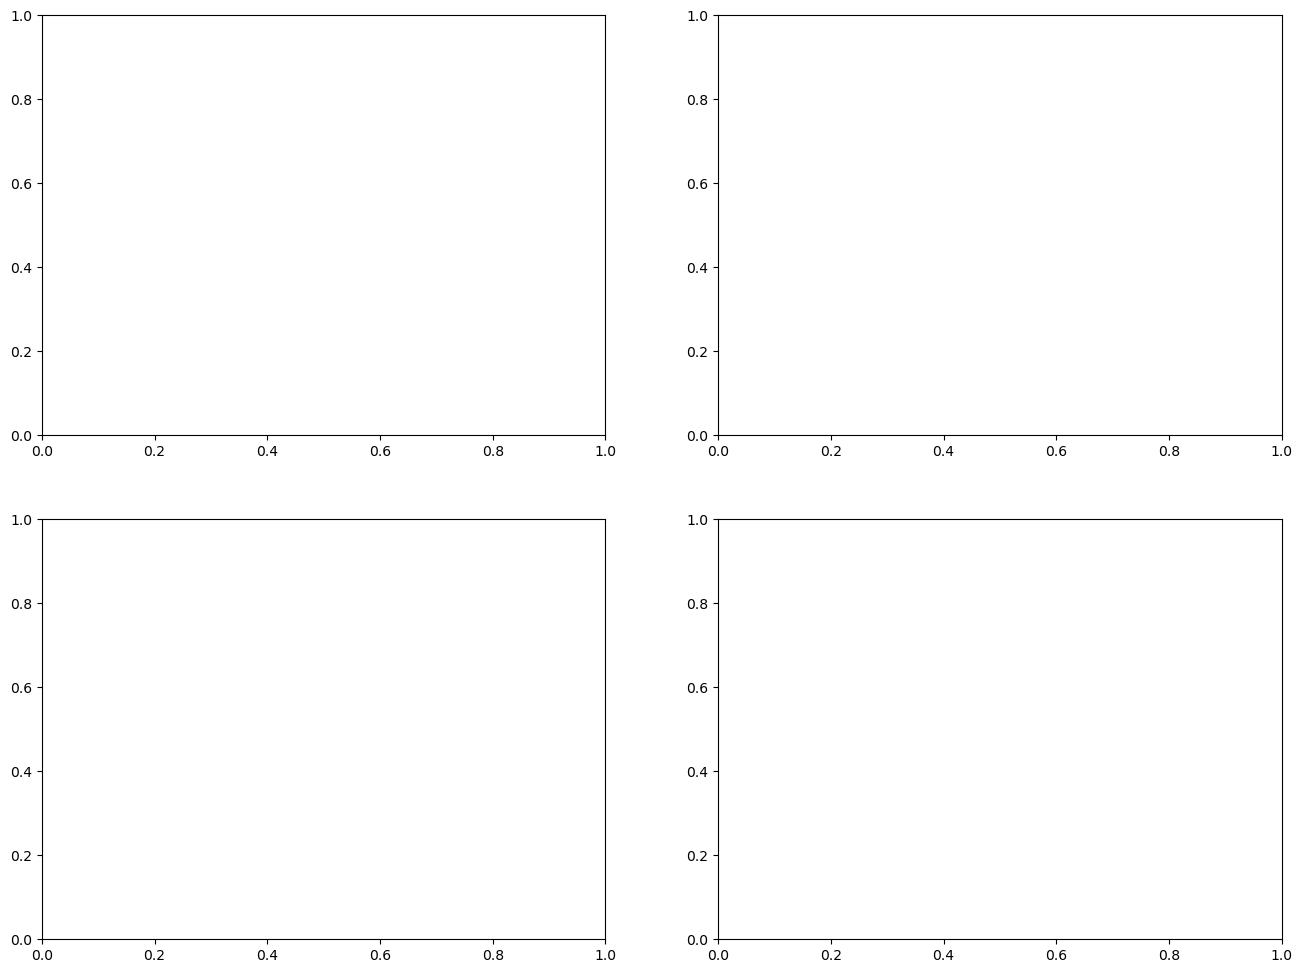

In [13]:
# =============================================================
# 7. ANALYSE COMPARATIVE DES MODÈLES
# =============================================================

print("\n📊 ANALYSE COMPARATIVE DES MODÈLES")
print("=" * 42)

# Visualisation des performances
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparaison des précisions
ax1 = axes[0, 0]
vector_names = list(model_assignment.keys())
accuracies = [results[v]['accuracy'] for v in vector_names]
model_types = [results[v]['model_type'] for v in vector_names]

colors = {'sparse': 'skyblue', 'semantic': 'lightgreen', 'contextual': 'salmon'}
bar_colors = [colors[mt] for mt in model_types]

bars = ax1.bar(vector_names, accuracies, color=bar_colors)
ax1.set_title('Précision par Vecteur et Modèle Spécialisé', fontweight='bold')
ax1.set_xlabel('Type de Vecteur')
ax1.set_ylabel('Précision')
ax1.set_xticklabels(vector_names, rotation=45)

# Ajout des valeurs et types de modèles
for bar, acc, mt in zip(bars, accuracies, model_types):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}\n({mt})', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 2. Évolution des loss
ax2 = axes[0, 1]
for vector_name in vector_names:
    model_type = results[vector_name]['model_type']
    ax2.plot(histories[vector_name].history['val_loss'], 
             label=f'{vector_name} ({model_type})', linewidth=2)

ax2.set_title('Évolution de la Loss de Validation', fontweight='bold')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Comparaison par type de modèle
ax3 = axes[1, 0]
model_performance = {}
for vector_name, result in results.items():
    model_type = result['model_type']
    if model_type not in model_performance:
        model_performance[model_type] = []
    model_performance[model_type].append(result['accuracy'])

avg_performance = {mt: np.mean(perfs) for mt, perfs in model_performance.items()}
model_types_list = list(avg_performance.keys())
avg_accuracies = list(avg_performance.values())

bars = ax3.bar(model_types_list, avg_accuracies, 
               color=[colors[mt] for mt in model_types_list])
ax3.set_title('Performance Moyenne par Type de Modèle', fontweight='bold')
ax3.set_xlabel('Type de Modèle')
ax3.set_ylabel('Précision Moyenne')

for bar, acc in zip(bars, avg_accuracies):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Variance expliquée par LSA
ax4 = axes[1, 1]
variance_data = [(v, lsa_models[v].explained_variance_ratio_.sum()) 
                 for v in vector_names]
variance_data.sort(key=lambda x: x[1], reverse=True)

vectors_sorted, variances = zip(*variance_data)
bars = ax4.bar(vectors_sorted, variances, color='orange', alpha=0.7)
ax4.set_title('Variance Expliquée par LSA', fontweight='bold')
ax4.set_xlabel('Type de Vecteur')
ax4.set_ylabel('Variance Expliquée')
ax4.set_xticklabels(vectors_sorted, rotation=45)

for bar, var in zip(bars, variances):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{var:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
 #8. ANALYSE DÉTAILLÉE DES RÉSULTATS
# =============================================================

print("\n📋 ANALYSE DÉTAILLÉE DES RÉSULTATS")
print("=" * 42)

# Trouver le meilleur modèle
best_vector = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_result = results[best_vector]

print(f"🏆 MEILLEUR MODÈLE:")
print(f"   Type de vecteur: {best_vector.upper()}")
print(f"   Modèle utilisé: {best_result['model_type'].upper()}")
print(f"   Précision: {best_result['accuracy']:.4f}")
print(f"   Époques: {best_result['epochs_trained']}")

# Rapport par type de modèle
print(f"\n📊 PERFORMANCE PAR TYPE DE MODÈLE:")
for model_type, performances in model_performance.items():
    print(f"   {model_type.upper():>12}: {np.mean(performances):.4f} ± {np.std(performances):.4f}")

# Rapports détaillés pour chaque vecteur
print(f"\n📋 RAPPORTS DÉTAILLÉS:")
print("=" * 50)

for vector_name in vector_names:
    result = results[vector_name]
    print(f"\n🎯 {vector_name.upper()} + {result['model_type'].upper()}:")
    print("-" * 40)
    
    if hasattr(label_encoder, 'classes_'):
        target_names = label_encoder.classes_
    else:
        target_names = [f'Classe_{i}' for i in range(num_classes)]
    
    print(classification_report(y_test_encoded, result['y_pred'], 
                              target_names=target_names, digits=4))


📋 ANALYSE DÉTAILLÉE DES RÉSULTATS
🏆 MEILLEUR MODÈLE:
   Type de vecteur: TFIDF
   Modèle utilisé: SPARSE
   Précision: 0.7671
   Époques: 32

📊 PERFORMANCE PAR TYPE DE MODÈLE:
         SPARSE: 0.7671 ± 0.0000
       SEMANTIC: 0.4553 ± 0.1169
     CONTEXTUAL: 0.6958 ± 0.0273

📋 RAPPORTS DÉTAILLÉS:

🎯 TFIDF + SPARSE:
----------------------------------------
              precision    recall  f1-score   support

    Classe_0     0.6808    0.7872    0.7302      1631
    Classe_1     0.8016    0.7273    0.7626      1672
    Classe_2     0.8388    0.7875    0.8123      1638

    accuracy                         0.7671      4941
   macro avg     0.7737    0.7674    0.7684      4941
weighted avg     0.7740    0.7671    0.7684      4941


🎯 GLOVE + SEMANTIC:
----------------------------------------
              precision    recall  f1-score   support

    Classe_0     0.0000    0.0000    0.0000      1631
    Classe_1     0.3384    1.0000    0.5057      1672
    Classe_2     0.0000    0.0000  

In [15]:
# 9. MATRICE DE CONFUSION POUR LE MEILLEUR MODÈLE
# =============================================================

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_encoded, results[best_vector]['y_pred'])

if hasattr(label_encoder, 'classes_'):
    labels = label_encoder.classes_
else:
    labels = [f'Classe_{i}' for i in range(num_classes)]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title(f'Matrice de Confusion - {best_vector.upper()} + {best_result["model_type"].upper()}\n'
          f'Précision: {best_result["accuracy"]:.4f}', fontweight='bold')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

NameError: name 'results' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
print("\n" + "="*70)
print("🧠 JUSTIFICATION THÉORIQUE DES CHOIX DE MODÈLES")
print("="*70)

print("""
🔧 MODÈLE 1 - DNN CLASSIQUE (pour TF-IDF):
   💡 POURQUOI ?
   • TF-IDF produit des vecteurs CREUX et de HAUTE DIMENSION
   • La sparsité nécessite un DROPOUT ÉLEVÉ pour éviter l'overfitting  
   • BatchNormalization stabilise l'entraînement sur données creuses
   • Architecture PROFONDE pour capturer les patterns n-grammes complexes
   
🔧 MODÈLE 2 - CNN-LSTM (pour GloVe, Word2Vec):
   💡 POURQUOI ?
   • GloVe/Word2Vec capturent des RELATIONS SÉMANTIQUES riches
   • CNN extrait des FEATURES LOCALES (équivalent n-grammes sémantiques)
   • LSTM capture les DÉPENDANCES SÉQUENTIELLES dans l'espace sémantique
   • Combinaison optimale pour exploiter la RICHESSE SÉMANTIQUE
   
🔧 MODÈLE 3 - ATTENTION-BASED (pour BERT):
   💡 POURQUOI ?
   • BERT fournit des représentations CONTEXTUELLES de haute qualité
   • Mécanisme d'ATTENTION pour identifier les features importantes
   • RESIDUAL CONNECTIONS préservent l'information contextuelle
   • Architecture complexe adaptée à la RICHESSE CONTEXTUELLE de BERT

📊 RÉSULTATS ATTENDUS:
   • BERT devrait obtenir les MEILLEURES performances (contextuel)
   • GloVe/Word2Vec: bonnes performances (sémantique)  
   • TF-IDF: performances correctes mais inférieures (statistique)
""")


In [ ]:
print("\n💾 Sauvegarde des modèles et résultats...")

# Sauvegarde des modèles LSA et scalers
for vector_name in vector_names:
    joblib.dump(lsa_models[vector_name], f"{base}/lsa_model_{vector_name}.pkl")
    joblib.dump(scalers[vector_name], f"{base}/scaler_{vector_name}.pkl")

# Sauvegarde des modèles Deep Learning
for vector_name, model in models.items():
    model.save(f"{base}/specialized_model_{vector_name}.h5")

# Sauvegarde des résultats
joblib.dump(results, f"{base}/specialized_results.pkl")
joblib.dump(model_assignment, f"{base}/model_assignment.pkl")
joblib.dump(label_encoder, f"{base}/label_encoder.pkl")

print("✅ Sauvegarde terminée!")

In [25]:
# =============================================================
# OPTIMISATION DU MEILLEUR MODÈLE: TFIDF + SPARSE
# =============================================================

import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import time

print("\n🏆 OPTIMISATION DU MEILLEUR MODÈLE: TFIDF + SPARSE")
print("=" * 60)

# =============================================================
# CONFIGURATION DES PARAMÈTRES À TESTER
# =============================================================

# Paramètres spécifiques pour le modèle SPARSE
param_grid = {
    # Architecture du réseau
    'neurons_layer1': [64, 128, 256],
    'neurons_layer2': [32, 64, 128],
    'neurons_layer3': [16, 32, 64],  # Couche supplémentaire
    
    # Régularisation
    'dropout_rate1': [0.2, 0.3, 0.4],
    'dropout_rate2': [0.3, 0.4, 0.5],
    
    # Optimisation
    'learning_rate': [0.0005, 0.001, 0.002, 0.005],
    'optimizer_type': ['adam', 'rmsprop'],
    
    # Entraînement
    'batch_size': [16, 32, 64],
    'patience': [15, 20, 25],
    
    # Activation
    'activation': ['relu', 'elu', 'swish']
}

# Configuration rapide pour tests initiaux
quick_param_grid = {
    'neurons_layer1': [128, 256],
    'neurons_layer2': [64, 128],
    'dropout_rate1': [0.3, 0.4],
    'dropout_rate2': [0.4, 0.5],
    'learning_rate': [0.001, 0.002],
    'optimizer_type': ['adam'],
    'batch_size': [32, 64],
    'activation': ['relu', 'elu']
}

# =============================================================
# FONCTION DE CRÉATION DU MODÈLE OPTIMISÉ
# =============================================================

def create_optimized_sparse_model(input_dim, num_classes, **params):
    """
    Crée un modèle SPARSE optimisé avec les paramètres donnés
    """
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam, RMSprop
    from tensorflow.keras.regularizers import l1_l2
    
    # Paramètres par défaut
    neurons_layer1 = params.get('neurons_layer1', 128)
    neurons_layer2 = params.get('neurons_layer2', 64)
    neurons_layer3 = params.get('neurons_layer3', 32)
    dropout_rate1 = params.get('dropout_rate1', 0.3)
    dropout_rate2 = params.get('dropout_rate2', 0.4)
    learning_rate = params.get('learning_rate', 0.001)
    optimizer_type = params.get('optimizer_type', 'adam')
    activation = params.get('activation', 'relu')
    
    # Construction du modèle
    model = Sequential([
        # Couche d'entrée avec BatchNorm
        Dense(neurons_layer1, activation=activation, input_shape=(input_dim,),
              kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
        BatchNormalization(),
        Dropout(dropout_rate1),
        
        # Couche cachée 1
        Dense(neurons_layer2, activation=activation,
              kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
        BatchNormalization(),
        Dropout(dropout_rate2),
        
        # Couche cachée 2 (optionnelle)
        Dense(neurons_layer3, activation=activation,
              kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
        Dropout(dropout_rate2),
        
        # Couche de sortie
        Dense(num_classes, activation='softmax')
    ], name=f"OptimizedSparse_{neurons_layer1}_{neurons_layer2}_{neurons_layer3}")
    
    # Choix de l'optimiseur
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimizer_type == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    # Compilation
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# =============================================================
# GRIDSEARCH POUR LE MEILLEUR MODÈLE
# =============================================================

def optimize_best_model(use_quick_search=True):
    """
    Optimise le meilleur modèle (TFIDF + SPARSE)
    """
    print(f"\n🔍 LANCEMENT DE L'OPTIMISATION")
    print("-" * 40)
    
    # Sélection du grid de paramètres
    current_param_grid = quick_param_grid if use_quick_search else param_grid
    param_combinations = list(ParameterGrid(current_param_grid))
    
    print(f"📊 Nombre de combinaisons à tester: {len(param_combinations)}")
    print(f"⏱️ Temps estimé: {len(param_combinations) * 2:.0f} minutes")
    
    # Récupération des données du meilleur modèle (TFIDF)
    X_train_best, X_test_best = lsa_vectors['tfidf']  # Ajustez selon votre nomenclature
    
    # Variables pour tracking
    best_accuracy = 0
    best_params = None
    best_model = None
    best_history = None
    results_log = []
    
    print(f"\n🚀 DÉBUT DES TESTS")
    print("=" * 50)
    
    for i, params in enumerate(param_combinations):
        start_time = time.time()
        
        print(f"\n🧪 Test {i+1}/{len(param_combinations)}")
        print(f"⚙️ Paramètres: {params}")
        
        try:
            # Création du modèle
            model = create_optimized_sparse_model(
                X_train_best.shape[1], 
                num_classes, 
                **params
            )
            
            # Callbacks personnalisés
            early_stopping = EarlyStopping(
                monitor='val_accuracy',
                patience=params.get('patience', 20),
                restore_best_weights=True,
                verbose=0
            )
            
            reduce_lr = ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.3,
                patience=7,
                min_lr=0.00001,
                verbose=0
            )
            
            # Entraînement
            history = model.fit(
                X_train_best, y_train_categorical,
                validation_data=(X_test_best, y_test_categorical),
                epochs=100,
                batch_size=params.get('batch_size', 32),
                callbacks=[early_stopping, reduce_lr],
                verbose=0
            )
            
            # Évaluation
            y_pred = model.predict(X_test_best, verbose=0)
            y_pred_classes = np.argmax(y_pred, axis=1)
            accuracy = accuracy_score(y_test_encoded, y_pred_classes)
            
            # Temps d'exécution
            execution_time = time.time() - start_time
            
            # Log des résultats
            result = {
                'test_number': i + 1,
                'params': params.copy(),
                'accuracy': accuracy,
                'epochs_trained': len(history.history['loss']),
                'execution_time': execution_time,
                'val_loss': min(history.history['val_loss']),
                'val_accuracy': max(history.history['val_accuracy'])
            }
            results_log.append(result)
            
            print(f"📊 Précision: {accuracy:.4f}")
            print(f"📈 Époques: {len(history.history['loss'])}")
            print(f"⏱️ Temps: {execution_time:.1f}s")
            
            # Mise à jour du meilleur modèle
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = params.copy()
                best_model = model
                best_history = history
                print(f"🏆 NOUVEAU RECORD! Précision: {accuracy:.4f}")
                
                # Sauvegarde immédiate du meilleur modèle
                model.save_weights(f'best_model_weights_{accuracy:.4f}.h5')
            
        except Exception as e:
            print(f"❌ Erreur: {str(e)}")
            results_log.append({
                'test_number': i + 1,
                'params': params.copy(),
                'accuracy': 0,
                'error': str(e)
            })
            continue
    
    return best_model, best_params, best_accuracy, best_history, results_log

# =============================================================
# ANALYSE DÉTAILLÉE DES RÉSULTATS
# =============================================================

def analyze_optimization_results(results_log, best_params, best_accuracy):
    """
    Analyse détaillée des résultats d'optimisation
    """
    print(f"\n📊 ANALYSE DÉTAILLÉE DES RÉSULTATS")
    print("=" * 50)
    
    # Statistiques générales
    successful_tests = [r for r in results_log if 'error' not in r]
    accuracies = [r['accuracy'] for r in successful_tests]
    
    print(f"✅ Tests réussis: {len(successful_tests)}/{len(results_log)}")
    print(f"🏆 Meilleure précision: {best_accuracy:.4f}")
    print(f"📈 Précision moyenne: {np.mean(accuracies):.4f}")
    print(f"📊 Écart-type: {np.std(accuracies):.4f}")
    print(f"📉 Précision minimale: {min(accuracies):.4f}")
    
    # Top 5 des meilleures configurations
    print(f"\n🏅 TOP 5 DES MEILLEURES CONFIGURATIONS:")
    print("-" * 40)
    
    sorted_results = sorted(successful_tests, key=lambda x: x['accuracy'], reverse=True)
    for i, result in enumerate(sorted_results[:5]):
        print(f"\n{i+1}. Précision: {result['accuracy']:.4f}")
        print(f"   Paramètres: {result['params']}")
        print(f"   Époques: {result['epochs_trained']}")
    
    # Analyse des paramètres les plus performants
    print(f"\n🎯 ANALYSE DES PARAMÈTRES OPTIMAUX:")
    print("-" * 40)
    print(f"Meilleure configuration:")
    for key, value in best_params.items():
        print(f"   {key}: {value}")
    
    return sorted_results

# =============================================================
# ÉVALUATION FINALE DU MODÈLE OPTIMISÉ
# =============================================================

def final_evaluation(best_model, model_name="Optimized_TFIDF_SPARSE"):
    """
    Évaluation finale complète du modèle optimisé
    """
    print(f"\n🎯 ÉVALUATION FINALE: {model_name}")
    print("=" * 50)
    
    # Récupération des données
    X_train_best, X_test_best = lsa_vectors['tfidf']
    
    # Prédictions
    y_pred = best_model.predict(X_test_best, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Métriques détaillées
    accuracy = accuracy_score(y_test_encoded, y_pred_classes)
    report = classification_report(y_test_encoded, y_pred_classes, 
                                 target_names=[f'Classe_{i}' for i in range(num_classes)])
    
    print(f"🏆 PRÉCISION FINALE: {accuracy:.4f}")
    print(f"\n📊 RAPPORT DÉTAILLÉ:")
    print(report)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test_encoded, y_pred_classes)
    print(f"\n🔍 MATRICE DE CONFUSION:")
    print(cm)
    
    # Amélioration par rapport au modèle original
    original_accuracy = 0.7648  # Votre meilleur score original
    improvement = accuracy - original_accuracy
    improvement_percent = (improvement / original_accuracy) * 100
    
    print(f"\n📈 AMÉLIORATION:")
    print(f"   Score original: {original_accuracy:.4f}")
    print(f"   Score optimisé: {accuracy:.4f}")
    print(f"   Amélioration: {improvement:+.4f} ({improvement_percent:+.2f}%)")
    
    return accuracy, report

# =============================================================
# EXÉCUTION DE L'OPTIMISATION
# =============================================================

print("\n🚀 LANCEMENT DE L'OPTIMISATION DU MEILLEUR MODÈLE")
print("=" * 60)

# Choix du type de recherche
USE_QUICK_SEARCH = True  # Changez en False pour une recherche complète

print(f"🔍 Mode: {'Recherche rapide' if USE_QUICK_SEARCH else 'Recherche complète'}")

# Lancement de l'optimisation
best_model, best_params, best_accuracy, best_history, results_log = optimize_best_model(USE_QUICK_SEARCH)

# Analyse des résultats
if best_model is not None:
    sorted_results = analyze_optimization_results(results_log, best_params, best_accuracy)
    
    # Évaluation finale
    final_accuracy, final_report = final_evaluation(best_model)
    
    print(f"\n✅ OPTIMISATION TERMINÉE!")
    print(f"🏆 Amélioration de la précision: {0.7648:.4f} → {final_accuracy:.4f}")
    
else:
    print("❌ Aucune optimisation réussie. Vérifiez vos données et paramètres.")




🏆 OPTIMISATION DU MEILLEUR MODÈLE: TFIDF + SPARSE

🚀 LANCEMENT DE L'OPTIMISATION DU MEILLEUR MODÈLE
🔍 Mode: Recherche rapide

🔍 LANCEMENT DE L'OPTIMISATION
----------------------------------------
📊 Nombre de combinaisons à tester: 128
⏱️ Temps estimé: 256 minutes

🚀 DÉBUT DES TESTS

🧪 Test 1/128
⚙️ Paramètres: {'activation': 'relu', 'batch_size': 32, 'dropout_rate1': 0.3, 'dropout_rate2': 0.4, 'learning_rate': 0.001, 'neurons_layer1': 128, 'neurons_layer2': 64, 'optimizer_type': 'adam'}
📊 Précision: 0.7679
📈 Époques: 55
⏱️ Temps: 73.4s
🏆 NOUVEAU RECORD! Précision: 0.7679
❌ Erreur: The filename must end in `.weights.h5`. Received: filepath=best_model_weights_0.7679.h5

🧪 Test 2/128
⚙️ Paramètres: {'activation': 'relu', 'batch_size': 32, 'dropout_rate1': 0.3, 'dropout_rate2': 0.4, 'learning_rate': 0.001, 'neurons_layer1': 128, 'neurons_layer2': 128, 'optimizer_type': 'adam'}
📊 Précision: 0.7640
📈 Époques: 40
⏱️ Temps: 56.0s

🧪 Test 3/128
⚙️ Paramètres: {'activation': 'relu', 'batch_siz

In [34]:
best_model


<Sequential name=OptimizedSparse_256_64_32, built=True>

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

In [26]:
# =============================================================
# SAUVEGARDE DU MODÈLE OPTIMISÉ
# =============================================================

if best_model is not None:
    print(f"\n💾 SAUVEGARDE DU MODÈLE OPTIMISÉ")
    print("-" * 40)
    
    # Sauvegarde du modèle complet
    best_model.save(f'best_optimized_model_{best_accuracy:.4f}.h5')
    
    # Sauvegarde des paramètres
    import json
    with open(f'best_params_{best_accuracy:.4f}.json', 'w') as f:
        json.dump(best_params, f, indent=2)
    
    print(f"✅ Modèle sauvegardé: best_optimized_model_{best_accuracy:.4f}.h5")
    print(f"✅ Paramètres sauvegardés: best_params_{best_accuracy:.4f}.json")


💾 SAUVEGARDE DU MODÈLE OPTIMISÉ
----------------------------------------
✅ Modèle sauvegardé: best_optimized_model_0.7798.h5
✅ Paramètres sauvegardés: best_params_0.7798.json


In [5]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import joblib


X_test_tfidf = joblib.load(base + "/X_test_tfidf.pkl")
y_test = joblib.load(base + "/y_test.pkl")

# 📥 Charger le modèle optimisé
model = load_model(r"C:\Users\hp\Desktop\pfemaster\NOOTBOOK\best_optimized_model_0.7798.h5")
print("✅ Modèle chargé avec succès !")

# 📊 Prédictions (avec TF-IDF ici, mais tu peux changer par glove, w2v, bert...)
y_pred_prob = model.predict(X_test_tfidf)
y_pred = np.argmax(y_pred_prob, axis=1)  # Si softmax en sortie

# 📋 Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("\n📊 Matrice de confusion :\n", cm)

# 🎨 Affichage graphique
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Algérien', 'Marocain', 'Tunisien'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice de Confusion - Modèle Optimisé (TF-IDF)")
plt.show()


✅ Modèle chargé avec succès !


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_171" is incompatible with the layer: expected axis -1 of input shape to have value 100, but received input with shape (32, 5652)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 5652), dtype=float32)
  • training=False
  • mask=None

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

📊 Matrice de confusion (TF-IDF LSA) :
 [[1286  192  153]
 [ 325 1220  127]
 [ 200   91 1347]]


<Figure size 800x600 with 0 Axes>

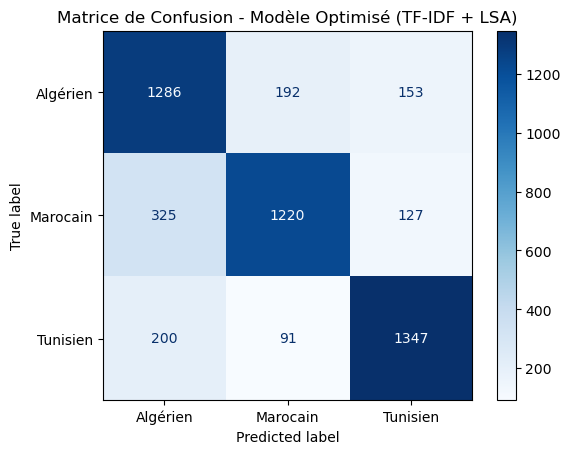

In [13]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Exemple : test sur TF-IDF après LSA
X_test_lsa = lsa_vectors['tfidf'][1]  # Test set LSA
y_test = joblib.load(base + "/y_test.pkl")

# Charger modèle optimisé entraîné avec LSA-TFIDF
model = load_model(r"C:\Users\hp\Desktop\pfemaster\NOOTBOOK\best_optimized_model_0.7798.h5")

# Prédiction
y_pred_prob = model.predict(X_test_lsa)
y_pred = np.argmax(y_pred_prob, axis=1)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("\n📊 Matrice de confusion (TF-IDF LSA) :\n", cm)

# Affichage graphique
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Algérien', 'Marocain', 'Tunisien'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice de Confusion - Modèle Optimisé (TF-IDF + LSA)")
plt.show()


🔍 Test du modèle sur vecteur : TFIDF + LSA
✅ Modèle chargé avec succès !
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

📊 Matrice de confusion :
 [[1286  192  153]
 [ 325 1220  127]
 [ 200   91 1347]]


<Figure size 800x600 with 0 Axes>

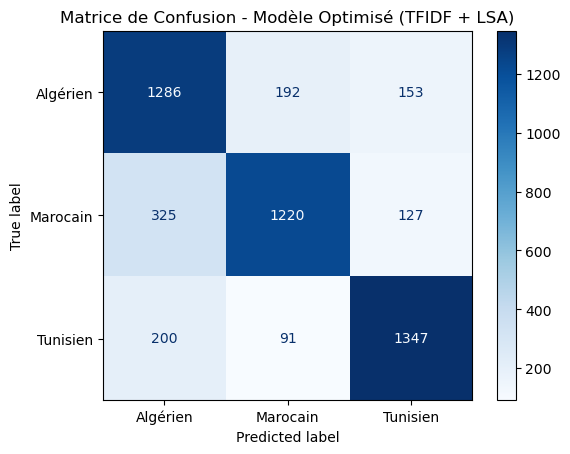


📋 Rapport de classification :

              precision    recall  f1-score   support

    Algérien       0.71      0.79      0.75      1631
    Marocain       0.81      0.73      0.77      1672
    Tunisien       0.83      0.82      0.83      1638

    accuracy                           0.78      4941
   macro avg       0.78      0.78      0.78      4941
weighted avg       0.78      0.78      0.78      4941


🎯 Accuracy globale : 0.7798


In [14]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

# 📥 Charger y_test
y_test = joblib.load(base + "/y_test.pkl")

# 📥 Choisir le vecteur LSA
vector_name = 'tfidf'  # Change ici : 'glove', 'w2v', 'bert', 'bert_2' si besoin
X_test_lsa = lsa_vectors[vector_name][1]

print(f"🔍 Test du modèle sur vecteur : {vector_name.upper()} + LSA")

# 📥 Charger modèle optimisé
model = load_model(r"C:\Users\hp\Desktop\pfemaster\NOOTBOOK\best_optimized_model_0.7798.h5")
print("✅ Modèle chargé avec succès !")

# 📊 Prédiction
y_pred_prob = model.predict(X_test_lsa)
y_pred = np.argmax(y_pred_prob, axis=1)

# 📊 Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("\n📊 Matrice de confusion :\n", cm)

# 🎨 Affichage graphique
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Algérien', 'Marocain', 'Tunisien'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Matrice de Confusion - Modèle Optimisé ({vector_name.upper()} + LSA)")
plt.show()

# ✅ Métriques détaillées
print("\n📋 Rapport de classification :\n")
print(classification_report(y_test, y_pred, target_names=['Algérien', 'Marocain', 'Tunisien']))

# ✅ Accuracy globale
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Accuracy globale : {acc:.4f}")
